In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from os import path
from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from linear_opt.lin_metabolism import SingleSubstrateMMRateLaw
from linear_opt.lin_metabolism import MultiSubstrateMMRateLaw
from matplotlib.ticker import LogFormatter 

colors = viz.plotting_style()
color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]
plt.style.use('style.mpl')

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_RE = 10
DEFAULT_RA = 0.3

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
#lam.print_model()

In [3]:
# Concentrations are typically ~1 mM, converting to mol/gCDW
# If the density rho ≈ 1000 g/L, 1/rho ≈ 1e-3 L/g = 1 mL/g so... 
# 1e-3 mol/L x 1e-3 L/g x 0.3 gDW/g x 2 gDW/gCDW = 1.5e-7 mol/gCDW
params = GrowthRateOptParams(min_phi_O=0.4, 
                             #rate_law=ZerothOrderRateLaw(),
                             do_dilution=True,
                             rate_law=SingleSubstrateMMRateLaw(),
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RE)
p = lam.max_growth_rate_problem(params)
p.solve(verbose=True)

#lam.solution_as_dict(p)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 30 05:07:53 PM: Your problem has 5 variables, 3 constraints, and 23 parameters.
(CVXPY) Aug 30 05:07:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 30 05:07:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 30 05:07:53 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 30 05:07:53 PM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Aug 30 05:07:53 PM: Applying reduction EvalParams
(CVXPY) Aug 30 05:07:53 PM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


1.343980153629763

In [4]:
# Do a quick run of the model to make sure it is feasible
params = GrowthRateOptParams(maintenance_cost=1e-6, phi_O=0.4)
opt, problem = lam.maximize_growth_rate(params)
opt

2.2870588142242774

In [5]:
concs = np.logspace(-7, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        opt, _ = lam.maximize_growth_rate(params)
        lambda_grid[i, j] = opt

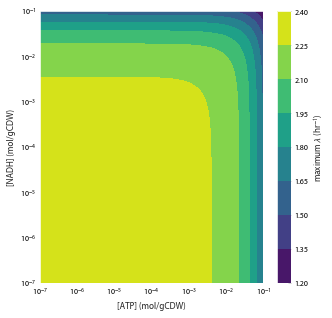

In [6]:
plt.figure(figsize=(5, 5))
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis')
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)')
plt.show()

In [7]:
# Same as above, multi-substrate michaelis menten rate law
concs = np.logspace(-8, -1, 50)
ATPgrid, NADHgrid = np.meshgrid(concs, concs)
lambda_grid = np.zeros_like(ATPgrid)

for i, ATP in enumerate(concs):
    for j, NADH in enumerate(concs):
        rl = MultiSubstrateMMRateLaw()
        params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True,
                                     fixed_ATP=ATP, fixed_NADH=NADH,
                                     fixed_re=10, fixed_ra=0.3,
                                     rate_law=rl)
        opt = np.NaN
        try:
            opt, _ = lam.maximize_growth_rate(params)
        except:
            # Optimal solution not found
            pass
        
        lambda_grid[i, j] = opt

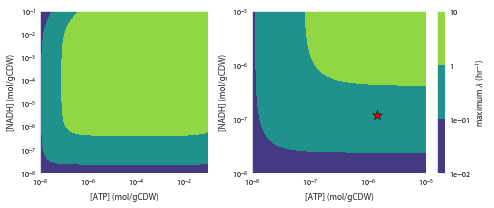

In [8]:
fig, axs = plt.subplots(figsize=(7, 3), ncols=2, width_ratios=[1, 1.3])

plt.sca(axs[0])
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')

plt.sca(axs[1])
# plot zoomed in on the range of ATP and NADH concentrations we care about
# which are 1e-8 to 1e-5 for both 
plt.xscale('log')
plt.yscale('log')
plt.contourf(ATPgrid, NADHgrid, lambda_grid, cmap='viridis', norm=LogNorm())
plt.xlabel('[ATP] (mol/gCDW)')
plt.ylabel('[NADH] (mol/gCDW)')
plt.xlim(1e-8, 1e-5)
plt.ylim(1e-8, 1e-5)
formatter = LogFormatter(10, labelOnlyBase=False)
cb = plt.colorbar(label=r'maximum $\lambda$ (hr$^{-1}$)', format=formatter)

# put a * at the Bennet concentrations of ATP ≈ 1.4e-6 (9.6 mM) and NADH ≈ 1.2e-7 (83 uM)
plt.scatter(DEFAULT_ATP, DEFAULT_NADH, marker='*', color='red', edgecolor='k', lw=0.5, s=100)

plt.tight_layout()
plt.show()

In [9]:
# Here is a model that has no homeostasis (phi_H <= 0),
# no maintenance (ATP_maint = 0), but can alter biomass
# composition through phi_O. We set a maximum lambda
# so that we can run the model over a range of lambda values.
params = GrowthRateOptParams(min_phi_O=0.4, do_dilution=True, 
                             max_lambda_hr=0.1, max_phi_H=0,
                             fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                             fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
                             
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
p = lam.max_growth_rate_problem(params)
lambdas = np.arange(0.1, 4, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.results_as_dict(p, params)
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,...,opt.fixed_ADP_mol_gCDW,opt.fixed_C_red_mol_gCDW,opt.fixed_ra,opt.fixed_re,opt.rate_law_name,opt.rate_law_order,analytic_lambda_zo,analytic_lambda_max_zo,S6_lb_zo,S6_ub_zo
0,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,4.200000e-07,1,0.3,10,ZeroOrder,0,0.10,0.10,0.15001,-1.200263
1,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,4.200000e-07,1,0.3,10,ZeroOrder,0,0.11,0.11,0.15001,-1.200263
2,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,4.200000e-07,1,0.3,10,ZeroOrder,0,0.12,0.12,0.15001,-1.200263
3,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,4.200000e-07,1,0.3,10,ZeroOrder,0,0.13,0.13,0.15001,-1.200263
4,100.0,2000.0,400.0,2000.0,100.0,2000.0,100.0,2000.0,0.0,0.0,...,4.200000e-07,1,0.3,10,ZeroOrder,0,0.14,0.14,0.15001,-1.200263


2.592


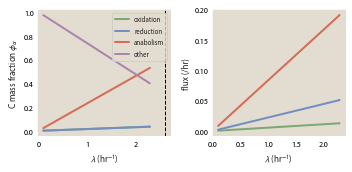

In [10]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
lambda_max = 12*3600*g_ana*(1-min_phi_O)
print(lambda_max)
plt.sca(axs[0])

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
processes = 'oxidation,reduction,anabolism'.split(',')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    plt.plot(x, phi_df[col], label=label, color=lin_colors[i])

plt.axvline(lambda_max, color='k', ls='--', lw=1) 
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'C mass fraction $\phi_\alpha$')   
plt.legend(loc=1)

plt.sca(axs[1])
j_cols = ['{}_flux'.format(p) for p in processes]
for i, col in enumerate(j_cols):
    plt.plot(x, phi_df[col]*3600, label=processes[i], color=lin_colors[i])
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')
plt.legend(loc=1).set_visible(False)

plt.tight_layout()
plt.show()


In [11]:
# Sweep a range of biomass ZC values
ZCBs = np.arange(-3, 3.01, 0.05)
phi_Os = np.arange(0.1,0.41,0.1)

results = []
lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)

for z in ZCBs:
    for phi_O in phi_Os:
        # Test with and without ATP homeostasis -- first with
        ref_lam = lmm.copy()
        ref_lam.set_ZCB(z)

        # Note we are fixing phi_O here to highlight the contribution of phi_H
        params = GrowthRateOptParams(min_phi_O=phi_O, do_dilution=True,
                                    fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                    fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params)
        d = ref_lam.model_as_dict()
        d.update(ref_lam.solution_as_dict(opt_p, params))
        d.update(params.as_dict())
        results.append(d)

        # Now without -- seting max_phi_H = 0
        params_nh = GrowthRateOptParams(min_phi_O=phi_O, do_dilution=True, max_phi_H=0,
                                        fixed_ATP=DEFAULT_ATP, fixed_NADH=DEFAULT_NADH,
                                        fixed_re=DEFAULT_RE, fixed_ra=DEFAULT_RA)
        m, opt_p = ref_lam.maximize_growth_rate(params_nh)
        d = ref_lam.results_as_dict(opt_p, params_nh)
        results.append(d)

zc_sensitivity_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


In [12]:
zc_sensitivity_df.S6_lb_zo

0          NaN
1      0.15001
2          NaN
3      0.15001
4          NaN
        ...   
963    0.15001
964        NaN
965    0.15001
966        NaN
967    0.15001
Name: S6_lb_zo, Length: 968, dtype: float64

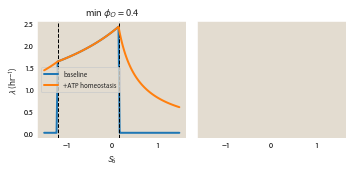

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.5), sharex=True, sharey=True)

ZCB = zc_sensitivity_df.ZCB.values[0]
my_phi_O = 0.4

plt.sca(axs[0])
plt.title(r'min $\phi_O$ = {0:.1f}'.format(my_phi_O))
mask = zc_sensitivity_df['min_phi_O'] == my_phi_O
masked = zc_sensitivity_df[mask]

phi_H_included = masked[masked['opt.max_phi_H_set'] == False]
no_phi_H = masked[masked['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.S6, no_phi_H.lambda_hr, label=r'baseline')
plt.plot(phi_H_included.S6, phi_H_included.lambda_hr, label=r'+ATP homeostasis', 
         zorder=10)

plt.axvline(no_phi_H.S6_lb_zo.values[0], color='k', ls='--', lw=1)
plt.axvline(no_phi_H.S6_ub_zo.values[0], color='k', ls='--', lw=1)


plt.legend()
plt.xlabel('$S_6$')
plt.ylabel(r'$\lambda$ (hr$^{-1}$)')
    
plt.tight_layout()
plt.show()

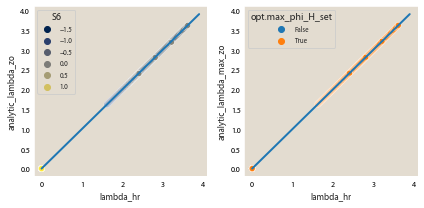

In [16]:

fig, axs = plt.subplots(ncols=2, figsize=(6,3))

mask = zc_sensitivity_df['opt_status'] == 'optimal'
masked = zc_sensitivity_df[mask]

plt.sca(axs[0])
sns.scatterplot(data=masked, x='lambda_hr', y='analytic_lambda_zo', hue='S6', palette='cividis')
xs = np.arange(0, 4, 0.1)
plt.plot(xs, xs)

plt.sca(axs[1])
sns.scatterplot(data=masked, x='lambda_hr', y='analytic_lambda_max_zo', hue='opt.max_phi_H_set')    
plt.plot(xs, xs)

plt.tight_layout()

plt.show()

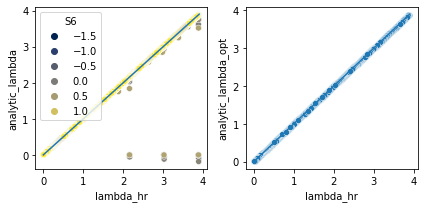

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6,3))

plt.sca(axs[0])
sns.scatterplot(data=res_df, x='lambda_hr', y='analytic_lambda', hue='S6', palette='cividis')
xs = np.arange(0, 4, 0.1)
plt.plot(xs, xs)

plt.sca(axs[1])
sns.scatterplot(data=res_df, x='lambda_hr', y='analytic_lambda_opt',)    
plt.plot(xs, xs)

plt.tight_layout()

plt.show()

<AxesSubplot: xlabel='lambda_hr', ylabel='analytic_lambda'>

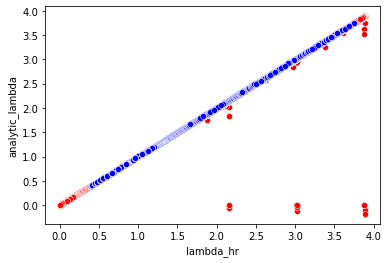

In [ ]:
sns.scatterplot(data=res_df[res_df.S6 > 0], x='lambda_hr', y='analytic_lambda', color='red')
sns.scatterplot(data=res_df[res_df.S6 <= 0], x='lambda_hr', y='analytic_lambda', color='blue')


